In [58]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import jax.random as jr
import kkr
import os, datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import tqdm
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
jax.config.update("jax_enable_x64", True)

In [60]:
STEPS = 14
DT = 1/ STEPS
N_TRAIN = 200
N_TEST = 50
D = 500
DEVICES = jax.devices("gpu")
LOAD_DATA = 0 
N_RUNS = 20

PRNGKey = jr.PRNGKey(44)
params_base_kernel = {"name": "square-exponential", "p_kernel":{"scale":0.1}}
save_path = os.path.join("results", "van_der_pol_risk"+"_" +datetime.datetime.today().strftime('%Y-%m-%d'))

In [61]:
def generate_data(N, STEPS, PRNGKey):
    dynamical_system = kkr.auxilliary.make_2d_ct_van_der_pol(*kkr.auxilliary.params_van_der_pol_optimal_construction)
    initial_conditions = kkr.auxilliary.sample_box(N, PRNGKey=PRNGKey)[0]
    return kkr.auxilliary.get_gamma_ivp(STEPS, initial_conditions, dynamical_system, DT)
def generate_eigenvalues_dt(D, PRNGKey=jax.random.PRNGKey(0)):
    return kkr.auxilliary.convert_2d_to_complex(kkr.auxilliary.sample_disk(D, random=True, PRNGKey=PRNGKey)[0])

In [62]:
os.makedirs(save_path, exist_ok=True)

if LOAD_DATA:
    data_load = kkr.auxilliary.load_trajectory_dict(os.path.join(save_path, "data.npz"))
    data_train = data_load["train"]
    data_test = data_load["test"]
else:
    PRNGKey, subkey = jr.split(PRNGKey)
    data = generate_data(N_TRAIN + N_TEST, STEPS, subkey)
    data_train = data.select_N([i for i in range(N_TRAIN)])
    data_test = data.select_N([i for i in range(N_TRAIN, N_TRAIN+N_TEST)])
    kkr.auxilliary.save_trajectory_dict(os.path.join(save_path, "data"), train=data_train, test=data_test)

In [63]:
def preprocess_data(data_train, data_test):
    preprocessor = {"x": MinMaxScaler((-1, 1)), "y": MinMaxScaler((-1, 1))}
    preprocessor["x"].fit(data_train["x"][:, 0, :])
    preprocessor["y"].fit(data_train["y"][:, 0, :])
    for d in [data_train, data_test]:
        for i in ["x", "y"]:
            d[i].set_X(preprocessor[i].transform(d[i].X.reshape(-1, d[i].d)).reshape(-1, d[i].H, d[i].d) )
    return preprocessor, data_train, data_test
def postprocess_data(data, preprocessor):
    for i in ["x", "y"]:
        data[i].X  = preprocessor[i].transform(data[i].X.reshape(-1, data[i].d)).reshape(-1, data[i].H, data[i].d)
    return  data

In [64]:
def square_error(x):
        return  jnp.sum(jnp.abs(x)**2) 
def fit_KKR_model(data_train, data_test, eigenvalues, lengthscale, result, run, device):
    KKR_model = kkr.model.kkr_estimator.KoopmanKernelDTRegressor(
        eigenvalues=eigenvalues,
        preprocessor=MinMaxScaler((-1., 1)),
        kernel_name=params_base_kernel["name"],
        kernel_params={"scale": lengthscale},
        timestep=DT,
        device=device,
        regularizer_invariant=1e-6,
        regularizer_isometric=1e-6
    )
    steps = data_train["y"].H-1
    KKR_model.fit(data_train["x"], data_train["y"])
    prediction_train = KKR_model.predict(data_train["x"][:, 0, :],steps)
    prediction_test = KKR_model.predict(data_test["x"][:, 0, :], steps)
    residual_train = data_train["y"]-prediction_train
    residual_test = data_test["y"]-prediction_test
    os.makedirs(os.path.join(save_path, "models"), exist_ok=True)
    KKR_model.save(os.path.join(save_path, "models", f"KKR_model_{run}.pkl"))

    L2_errors_train = kkr.auxilliary.p_norm((residual_train).X, [0, 1, 2], 2)
    L2_errors_test = kkr.auxilliary.p_norm((residual_test).X, [0, 1, 2], 2)
    square_error_train = square_error((residual_train).X)
    square_error_test = square_error((residual_test).X)
    result[str(run)] = {"lengthscale": lengthscale, "L2_errors_train": L2_errors_train, "L2_errors_test": L2_errors_test, "steps": steps, 
                        "square_error_train":square_error_train, "square_error_test":square_error_test, "N":data_train["x"].N, 
                        "data_test": data_test, "data_train": data_train, "prediction_test": prediction_test, "prediction_train": prediction_train}
    return result


def experiment(rng, N_TRAIN, result, run, device):
    rng, subkey = jr.split(rng)
    data = generate_data(N_TRAIN + N_TEST, STEPS, subkey)
    data_train = data.select_N([i for i in range(N_TRAIN)])
    data_test = data.select_N([i for i in range(N_TRAIN, N_TRAIN+N_TEST)])
    data_train = {"x":data_train, "y":data_train}
    data_test = {"x":data_test, "y":data_test}
    rng, subkey = jr.split(rng)
    eigenvalues = generate_eigenvalues_dt(D, subkey)
    preprocessor = preprocess_data(data_train, data_test)
    result = fit_KKR_model(data_train, data_test,
                           eigenvalues, params_base_kernel["p_kernel"]["scale"], result, run, device)
    return result, preprocessor

## Setup tasks

In [65]:
PRNGKey, subkey = jr.split(PRNGKey)
variation_rng = rng_runs = jr.split(subkey, N_RUNS)
variation_n_train = jnp.unique(jnp.asarray(jnp.round(jnp.logspace(0.8, jnp.log10(N_TRAIN), 20), 0), dtype=int))
print(variation_n_train)
tasks =list(product(variation_rng, variation_n_train))

[  6   8   9  11  13  16  19  23  27  32  39  47  56  67  81  97 116 139
 167 200]


## Run experiments

In [66]:
logger = tqdm.tqdm_notebook(total = len(tasks))
log = lambda x: logger.update(x)
workers = kkr.auxilliary.multithreading.tmap(experiment, DEVICES, log=log)
results = workers(tasks)

## Postprocess data


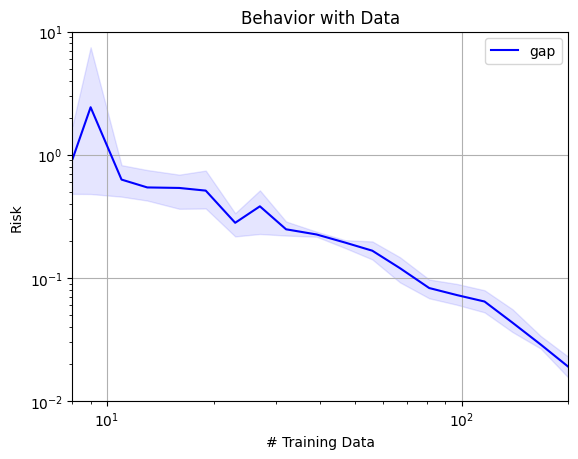

In [71]:
results_arr = jnp.array([(float(results[k]["N"]), float(results[k]["L2_errors_train"]**2), float(results[k]["L2_errors_test"]**2), abs(float(results[k]["L2_errors_train"]**2)-float(results[k]["L2_errors_test"]**2))) for k in results.keys()])
# results_arr = jnp.array([(float(results[k]["N"]), float(results[k]["square_error_train"]), float(results[k]["square_error_test"]), abs(float(results[k]["square_error_test"])-float(results[k]["square_error_train"]))) for k in results.keys()])

results_arr = results_arr[results_arr[:, 0].argsort()]
results_arr_means = jnp.stack([results_arr[ls == results_arr[:, 0]].mean(axis=0) for ls in variation_n_train])
results_arr_max = jnp.stack([results_arr[ls == results_arr[:, 0]].max(axis=0) for ls in variation_n_train])
results_arr_min = jnp.stack([results_arr[ls == results_arr[:, 0]].min(axis=0) for ls in variation_n_train])
with open(os.path.join(save_path, "simulation_results.pkl"), "wb") as f:
    pickle.dump(results, f)
plt.plot(results_arr_means[:, 0], results_arr_means[:, 3],
         "blue", label="gap")
plt.fill_between(results_arr_min[:, 0], results_arr_min[:, 3],
                 results_arr_max[:, 3], color="blue", alpha=0.1)
plt.xlabel("# Training Data");plt.ylabel("Risk")
plt.title("Behavior with Data")
plt.legend();plt.grid();plt.loglog();plt.legend();plt.ylim(1e-2, 1e1);plt.xlim(8, 2e2);